In [ ]:
import os, pickle, warnings, dataclasses, itertools
from pathlib import Path
from functools import partial 

import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy import stats as st

import torch
from torch import nn
from torch.nn import functional as F

from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from typing import Iterable, Tuple

import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

import transformers
transformers.logging.set_verbosity_error()

%load_ext autoreload
%autoreload 1
%aimport salford_datasets.salford, salford_datasets.salford_raw, transformer_experiment.utils.embeddings, acd_experiment.sci

from salford_datasets.salford import SalfordData, SalfordFeatures, SalfordPrettyPrint, SalfordCombinations
from salford_datasets.utils import DotDict

In [ ]:
class Notebook:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    DATA_DIR = Path('data/Salford/')
    RE_DERIVE = False

In [ ]:
from transformer_experiment.utils.embeddings import get_sci_indexes

SAL = load_sal(Notebook.RE_DERIVE, Notebook.DATA_DIR)
SAL_TRAIN, SAL_TEST, SAL_TEST_UNSEEN, SAL_TEST_PRECOVID = list(map(lambda _: SAL[SAL.index.isin(_)], get_sci_indexes()))

/home2/kqcr86/acute-care-pathways/acd_experiment/sci.py:419: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  column_where_critical_appeared = m.idxmax(axis=1).where(m.any(1)).dropna()


In [20]:
BERTModels = DotDict(
    BioClinicalBert="emilyalsentzer/Bio_ClinicalBERT",
    Bert="distilbert-base-uncased",
    PubMedBert="ml4pubmed/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext_pub_section"
)

Experiments: 
 1. Tabular Data only
 2. Note Embeddings Only
 3. Tabular & Note Embeddings
    - One model for both
    - Ensemble separate models
 4. Note Transformer
 5. LightGBM for Tabular and Transformer for Notes Ensemble
 6. Text-ified record Transformer
 7. Note & Text-ified record Transformer
    - One model for both
    - Ensemble separate models 


In [28]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, roc_auc_score, average_precision_score, fbeta_score, make_scorer
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

CROSS_VALIDATION_METRICS = dict(
    Precision='precision',
    Recall='recall',
    AUC='roc_auc',
    AP='average_precision',
    F1='f1',
    F2=make_scorer(fbeta_score, beta=2)
)

LIGHTGBM_PARAMETERS = dict(
    objective='binary',
    random_state=123,
    metrics=['l2', 'auc'],
    boosting_type='gbdt',
    is_unbalance=True,
    n_jobs=1
)

REGRESSION_PARAMETERS = dict(
    max_iter=5000,
    solver='lbfgs',
    random_state=123,
    penalty='l2'
)

CALIBRATION_PARAMETERS = dict(
    ensemble=True,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=123),
    method='isotonic',
    n_jobs=4
)

CROSS_VALIDATION_PARAMETERS = dict(
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=123),
    n_jobs=1,
    scoring=CROSS_VALIDATION_METRICS
)

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer

REGRESSION_PREPROCESSOR = make_column_transformer(
    (OneHotEncoder(), make_column_selector(dtype_include='category')),
    (SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number)),
    remainder='passthrough'
)

In [33]:
from sklearn.calibration import IsotonicRegression
def run_shallow_CV_experiments(X_variants, y):
    classifiers = {
        'LightGBM': LGBMClassifier(
            **LIGHTGBM_PARAMETERS
        ),
        # 'LR-L2': LogisticRegression(   
        #     **REGRESSION_PARAMETERS
        # )
    }

    experiments = itertools.product(X_variants.items(), classifiers.items())

    results = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for (X_name, X), (classifier_name, classifier) in (pbar := tqdm(experiments)):
            pbar.set_description(f'Parallel running 4 CV folds of {classifier_name} with {X_name} embeddings..')
            if classifier_name == 'LR-L2':
                X = REGRESSION_PREPROCESSOR.fit_transform(X)

            results.append(pd.DataFrame.from_dict(
                cross_validate(
                    CalibratedClassifierCV(classifier, **CALIBRATION_PARAMETERS),
                    X, y, **CROSS_VALIDATION_PARAMETERS
                )
            ).assign(Embedding=X_name, Classifier=classifier_name))
    

    return pd.concat(results).groupby(['Embedding', 'Classifier']).mean()

## 1. Tabular Classifier

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def cv_tabular_classifier(sal):
    X = SalfordData(sal[SalfordCombinations.with_services]).convert_str_to_categorical()
    y = sal.CriticalEvent
    X_variants = {
        key: X[columns] for key, columns in SalfordCombinations.items()
    }

    return run_shallow_CV_experiments(X_variants, y)

if Notebook.RE_DERIVE:
    RESULTS_1 = cv_tabular_classifier(SAL)
    RESULTS_1.to_csv('data/cache/result1.csv')
else:
    RESULTS_1 = pd.read_csv('data/cache/result1.csv').set_index(['Embedding', 'Classifier'])

display(RESULTS_1)

fit_time  score_time  test_Precision  \
Embedding       Classifier                                           
news            LR-L2         8.647021    0.258225        0.000000   
                LightGBM      2.506067    0.990190        0.545704   
with_composites LR-L2        96.810492    0.252361        0.657983   
                LightGBM      5.015228    2.101757        0.677930   
with_labs       LR-L2       730.570759    0.352537        0.567155   
                LightGBM      7.765831    2.990653        0.672319   
with_phenotype  LR-L2        62.047589    0.225753        0.723203   
                LightGBM      4.441151    1.745080        0.697218   
with_services   LR-L2       221.962656    0.234918        0.877467   
                LightGBM      8.059408    3.304551        0.839739   

                            test_Recall  test_AUC   test_AP   test_F1  \
Embedding       Classifier                                              
news            LR-L2          0.000000  0.594588  0.088105  0.000000   
                LightGBM       0.003920  0.690098  0.133228  0.007783   
with_composites LR-L2          0.051477  0.788370  0.246132  0.095479   
                LightGBM       0.118125  0.846199  0.326153  0.201150   
with_labs       LR-L2          0.083580  0.842708  0.280948  0.145647   
                LightGBM       0.220170  0.918216  0.466192  0.331701   
with_phenotype  LR-L2          0.039432  0.680067  0.174806  0.074742   
                LightGBM       0.057443  0.768164  0.230990  0.106084   
with_services   LR-L2          0.364489  0.913015  0.601378  0.514847   
                LightGBM       0.486648  0.958504  0.719494  0.616178   

                             test_F2  
Embedding       Classifier            
news            LR-L2       0.000000  
                LightGBM    0.004891  
with_composites LR-L2       0.063111  
                LightGBM    0.141483  
with_labs       LR-L2       0.100753  
                LightGBM    0.254383  
with_phenotype  LR-L2       0.048619  
                LightGBM    0.070344  
with_services   LR-L2       0.412686  
                LightGBM    0.531323

## 2. Note Embedding Classifier

In [26]:
from transformers import AutoTokenizer, AutoModel
    
def load_tz_to_device(tz_output):
    """ Given the direct output of the tokeniser, loads the tokens to the GPU """
    return dict(map(
        lambda _: (_[0], _[1].to(Notebook.DEVICE)), tz_output.items()
    ))

def split_into_batches(Xt, batch_size):
    """ Given a tensor/ndarray and a batch size, splits it into batches of size up to batch_size along the first dimension """
    return np.array_split(
        Xt, np.ceil(len(Xt)/batch_size)
    )

def get_note_embeddings(X, model_uri=BERTModels.BioClinicalBert):
    tz, model = AutoTokenizer.from_pretrained(model_uri), AutoModel.from_pretrained(model_uri).to(Notebook.DEVICE).eval()
    tz_kwargs = dict(truncation=True, padding=True, return_tensors='pt')

    get_batch_embedding = lambda x: (
        model(
            **load_tz_to_device(tz(list(x), **tz_kwargs))
        )['last_hidden_state'][:, 0, :].cpu()
    )

    with torch.no_grad():
        emb = torch.cat([
            get_batch_embedding(_) for _ in tqdm(split_into_batches(X, 500), desc="Generating embeddings..")
        ])
    
    return emb

def get_note_embeddings_all_BERTs(sal):
    columns = ['AE_TriageNote', 'AE_MainDiagnosis', 'AE_PresentingComplaint']
    avail_idx = sal[columns].notna().any(axis=1)
    X = SalfordData(sal.loc[avail_idx]).tabular_to_text(columns).values

    with torch.no_grad():
        result = {
            model_name: get_note_embeddings(X, model_uri) for model_name, model_uri in BERTModels.items()
        }

    return result, avail_idx

if Notebook.RE_DERIVE:
    NOTE_EMBEDDINGS, note_avail_idx = get_note_embeddings_all_BERTs(pd.concat((SAL_TRAIN, SAL_TEST)))
    with open('data/cache/note_embeddings_sci.bin', 'wb') as file:
        pickle.dump((NOTE_EMBEDDINGS, note_avail_idx), file)
else:
    with open('data/cache/note_embeddings_sci.bin', 'rb') as file:
        (NOTE_EMBEDDINGS, note_avail_idx) = pickle.load(file)

Generating embeddings..: 100%|██████████| 218/218 [08:58<00:00,  2.47s/it]


In [10]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def cv_embedding_only_classifier(sal, embeddings_dict, avail_idx):
    y = sal.loc[avail_idx, 'CriticalEvent'].astype(int)
    X_variants = {
        model_name: X.numpy() for model_name, X in embeddings_dict.items()
    }

    return run_shallow_CV_experiments(X_variants, y)

if Notebook.RE_DERIVE:
    RESULTS_2 = train_embedding_only_classifier(SAL, NOTE_EMBEDDINGS, note_avail_idx)
    RESULTS_2.to_csv('data/cache/result2.csv')
else:
    RESULTS_2 = pd.read_csv('data/cache/result2.csv').set_index(['Embedding', 'Classifier'])

display(RESULTS_2)

fit_time  score_time  test_Precision  \
Embedding       Classifier                                           
Bert            LR-L2       481.301529    1.944320        0.660414   
                LightGBM    331.267331    4.631080        0.614847   
BioClinicalBert LR-L2       935.784982    2.264355        0.702388   
                LightGBM    319.884479    4.630379        0.635437   
PubMedBert      LR-L2       962.396765    4.411551        0.637574   
                LightGBM    330.919344    4.579374        0.618268   

                            test_Recall  test_AUC   test_AP   test_F1  \
Embedding       Classifier                                              
Bert            LR-L2          0.121317  0.837179  0.328124  0.204883   
                LightGBM       0.046985  0.825350  0.273014  0.087234   
BioClinicalBert LR-L2          0.131871  0.847504  0.346662  0.221900   
                LightGBM       0.069744  0.839576  0.288721  0.125588   
PubMedBert      LR-L2          0.143250  0.851519  0.342452  0.233855   
                LightGBM       0.094246  0.847822  0.308226  0.163392   

                             test_F2  
Embedding       Classifier            
Bert            LR-L2       0.144966  
                LightGBM    0.057619  
BioClinicalBert LR-L2       0.157414  
                LightGBM    0.084831  
PubMedBert      LR-L2       0.169519  
                LightGBM    0.113447

## 3. Tabular & Embedding Classifier

### 3.1 One Classifier for Both

In [11]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def cv_tabular_and_embedding_classifier(sal, embeddings_dict, avail_idx):
    X = SalfordData(sal.loc[avail_idx, SalfordCombinations.with_services]).convert_str_to_categorical()
    y = sal.loc[avail_idx, 'CriticalEvent']

    X_variants = {
        transformer: pd.concat((X, pd.DataFrame(embedding).add_prefix('EMBEDDING__').set_index(X.index)), axis=1)
        for transformer, embedding in embeddings_dict.items()
    }

    return run_shallow_CV_experiments(X_variants, y)

if Notebook.RE_DERIVE:
    RESULTS_31 = cv_tabular_and_embedding_classifier(SAL, NOTE_EMBEDDINGS, note_avail_idx)
    RESULTS_31.to_csv('data/cache/result31.csv')
else:
    RESULTS_31 = pd.read_csv('data/cache/result31.csv').set_index(['Embedding', 'Classifier'])

display(RESULTS_31)

fit_time  score_time  test_Precision  \
Embedding       Classifier                                            
Bert            LR-L2       3446.892846    0.930931        0.865875   
                LightGBM     358.325441   31.259331        0.882465   
BioClinicalBert LR-L2       3449.244502    1.012600        0.866191   
                LightGBM     362.900432   31.037868        0.881836   
PubMedBert      LR-L2       3425.869108    0.895057        0.859471   
                LightGBM     357.951831   30.942927        0.883045   

                            test_Recall  test_AUC   test_AP   test_F1  \
Embedding       Classifier                                              
Bert            LR-L2          0.470312  0.936871  0.677538  0.609427   
                LightGBM       0.493255  0.954317  0.720029  0.632744   
BioClinicalBert LR-L2          0.472424  0.939958  0.685728  0.611361   
                LightGBM       0.493988  0.955296  0.721962  0.633221   
PubMedBert      LR-L2          0.473157  0.940401  0.685249  0.610311   
                LightGBM       0.498577  0.955592  0.723896  0.637251   

                             test_F2  
Embedding       Classifier            
Bert            LR-L2       0.517559  
                LightGBM    0.540950  
BioClinicalBert LR-L2       0.519660  
                LightGBM    0.541623  
PubMedBert      LR-L2       0.519890  
                LightGBM    0.546107

### 3.2 Ensembles

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def cv_tabular_and_embedding_ensemble(sal, embeddings_dict, avail_idx):
    tabular_columns = SalfordCombinations.with_services
    X = SalfordData(sal.loc[avail_idx, tabular_columns]).convert_str_to_categorical()
    y = sal.loc[avail_idx, 'CriticalEvent']

    X_variants = {
        transformer: pd.concat((X, pd.DataFrame(embedding).add_prefix(f'EMBEDDING__').set_index(X.index)), axis=1)
        for transformer, embedding in embeddings_dict.items()
    }

    embedding_selector = make_column_transformer(('passthrough', make_column_selector(pattern='EMBEDDING__'))).set_output(transform='pandas')
    data_selector = make_column_transformer(('passthrough', tabular_columns)).set_output(transform='pandas')

    classifier_factory = {
        'LightGBM': lambda selector: make_pipeline(
            selector, 
            CalibratedClassifierCV(
                LGBMClassifier(**LIGHTGBM_PARAMETERS), **CALIBRATION_PARAMETERS
            )),
        'LR-L2': lambda selector: make_pipeline(
            selector, 
            REGRESSION_PREPROCESSOR, 
            CalibratedClassifierCV(
                LogisticRegression(**REGRESSION_PARAMETERS), **CALIBRATION_PARAMETERS
            ))
    }

    experiments = itertools.product(
        X_variants.items(), 
        itertools.product(classifier_factory.items(), repeat=2)
    )

    cross_validation_parameters = CROSS_VALIDATION_PARAMETERS | dict(
        n_jobs=4
    )

    results = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for (X_name, X), ((cls_name_data, cls_factory_data), (cls_name_embeddings, cls_factory_embeddings)) in (pbar := tqdm(experiments)):
            pbar.set_description(f'Parallel running 4 CV folds of {cls_name_data}-{cls_name_embeddings} with {X_name} embeddings..')

            ensemble = VotingClassifier([
                (f'DATA_{cls_name_data}', cls_factory_data(data_selector)),
                (f'EMB_{cls_name_embeddings}', cls_factory_embeddings(embedding_selector)),
            ], voting='soft')

            results.append(pd.DataFrame.from_dict(
                cross_validate(
                    ensemble,
                    X, y, **cross_validation_parameters
                )
            ).assign(Embedding=X_name, Classifier_Data=cls_name_data, Classifier_Emb=cls_name_embeddings))

        return pd.concat(results).groupby(['Embedding', 'Classifier_Data', 'Classifier_Emb']).mean()

if Notebook.RE_DERIVE:
    RESULTS_32 = cv_tabular_and_embedding_ensemble(SAL, NOTE_EMBEDDINGS, note_avail_idx)
    RESULTS_32.to_csv('data/cache/result32.csv')
else:
    RESULTS_32 = pd.read_csv('data/cache/result32.csv').set_index(['Embedding', 'Classifier_Data', 'Classifier_Emb'])

display(RESULTS_32)

fit_time  score_time  \
Embedding       Classifier_Data Classifier_Emb                            
Bert            LR-L2           LR-L2            750.592701    0.542523   
                                LightGBM         606.041267    0.415372   
                LightGBM        LR-L2            473.115724   10.148475   
                                LightGBM         324.754093   11.136703   
BioClinicalBert LR-L2           LR-L2           1329.363483    0.484679   
                                LightGBM         826.312274    0.437503   
                LightGBM        LR-L2            998.361817   12.950396   
                                LightGBM         332.994291   11.442362   
PubMedBert      LR-L2           LR-L2            809.081656    0.537361   
                                LightGBM         600.526571    0.408377   
                LightGBM        LR-L2            534.709834   11.378677   
                                LightGBM         321.624973   11.094053   

                                                test_Precision  test_Recall  \
Embedding       Classifier_Data Classifier_Emb                                
Bert            LR-L2           LR-L2                      NaN          NaN   
                                LightGBM                   NaN          NaN   
                LightGBM        LR-L2                 0.951664     0.372763   
                                LightGBM              0.959971     0.353492   
BioClinicalBert LR-L2           LR-L2                      NaN          NaN   
                                LightGBM                   NaN          NaN   
                LightGBM        LR-L2                 0.951735     0.372763   
                                LightGBM              0.959222     0.359640   
PubMedBert      LR-L2           LR-L2                      NaN          NaN   
                                LightGBM                   NaN          NaN   
                LightGBM        LR-L2                 0.947544     0.375424   
                                LightGBM              0.955047     0.365881   

                                                test_AUC   test_AP   test_F1  \
Embedding       Classifier_Data Classifier_Emb                                 
Bert            LR-L2           LR-L2                NaN       NaN       NaN   
                                LightGBM             NaN       NaN       NaN   
                LightGBM        LR-L2           0.945833  0.699402  0.535621   
                                LightGBM        0.944035  0.697140  0.516642   
BioClinicalBert LR-L2           LR-L2                NaN       NaN       NaN   
                                LightGBM             NaN       NaN       NaN   
                LightGBM        LR-L2           0.947542  0.704964  0.535624   
                                LightGBM        0.945917  0.699079  0.523088   
PubMedBert      LR-L2           LR-L2                NaN       NaN       NaN   
                                LightGBM             NaN       NaN       NaN   
                LightGBM        LR-L2           0.947792  0.703842  0.537694   
                                LightGBM        0.946992  0.700792  0.528973   

                                                 test_F2  
Embedding       Classifier_Data Classifier_Emb            
Bert            LR-L2           LR-L2                NaN  
                                LightGBM             NaN  
                LightGBM        LR-L2           0.424372  
                                LightGBM        0.404595  
BioClinicalBert LR-L2           LR-L2                NaN  
                                LightGBM             NaN  
                LightGBM        LR-L2           0.424371  
                                LightGBM        0.411008  
PubMedBert      LR-L2           LR-L2                NaN  
                                LightGBM             NaN  
                LightGBM        LR-L2           0.426960  
     

## Final Shallow Classifier

One shallow classifier (LightGBM) for both tabular and embeddings performs the best at this stage. We train one using the temporal train-test split and apply SHAP

,Accuracy,Precision,Recall,AP,F2 Score,AUC,AUC_CI
Model,0.844617,0.114314,0.85049,0.513033,0.371719,0.925861,0.926 (0.917-0.934)


(       Accuracy  Precision   Recall        AP  F2 Score       AUC  \
 Model  0.844617   0.114314  0.85049  0.513033  0.371719  0.925861   
 
                     AUC_CI  
 Model  0.926 (0.917-0.934)  ,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f03a99cd930>)

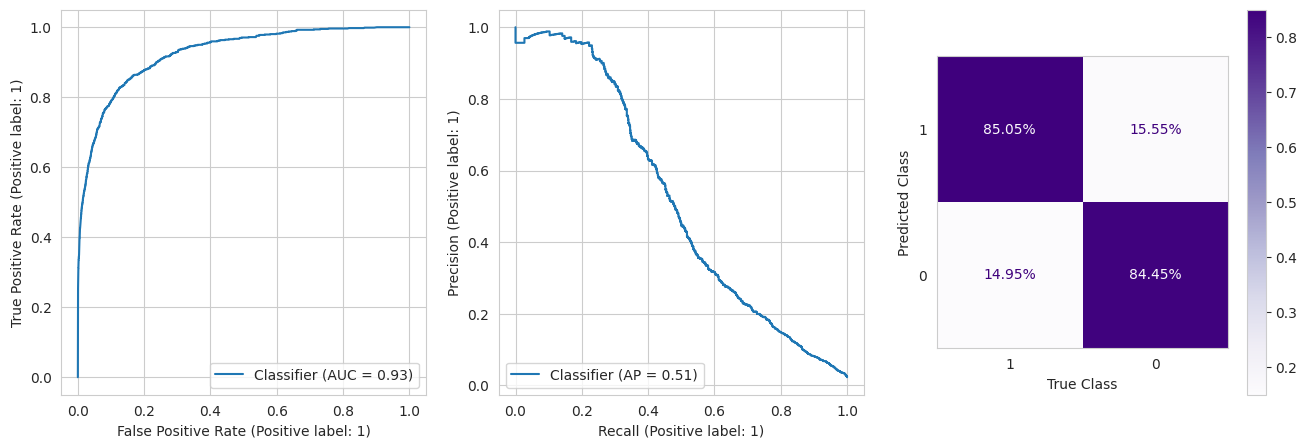

In [147]:
from transformer_experiment.utils.embeddings import evaluate_from_pred
import optuna 
from acd_experiment.models import Estimator_LightGBM
from acd_experiment.salford_adapter import SalfordAdapter


os.environ["TOKENIZERS_PARALLELISM"] = "false"

def train_final_shallow_embedding_classifier(sal, embeddings_dict, avail_idx, bert_model='BioClinicalBert'):
    params = optuna.load_study(
        study_name =f'LightGBM_None_Within-1_with_notes_and_labs', storage=f'sqlite:///data/systematic_comparison/LightGBM.db'
    ).best_params
    params = params | LIGHTGBM_PARAMETERS

    X = SalfordData(
        sal.sort_values('AdmissionDate').loc[avail_idx, SalfordCombinations.with_services]
    ).convert_str_to_categorical()
    X = pd.concat((X, pd.DataFrame(embeddings_dict[bert_model]).add_prefix(f'EMBEDDING__').set_index(X.index)), axis=1)
    y = sal.loc[avail_idx, 'CriticalEvent']

    X_train, X_test = X[X.index.isin(SAL_TRAIN.index)], X[X.index.isin(SAL_TEST.index)]
    y_train, y_test = y[X_train.index], y[X_test.index]

    
    classifier = CalibratedClassifierCV(
        LGBMClassifier(**params), 
    cv=4, method='isotonic', n_jobs=4).fit(X_train, y_train)

    y_pred_proba = classifier.predict_proba(X_test)[:,1]
    evaluate_from_pred(y_test, y_pred_proba)

    explanations = Estimator_LightGBM.explain_calibrated(
        model, X_train, SalfordAdapter(X_test), cv_jobs=4
    )

    return classifier, y_pred_proba, explanations

if Notebook.RE_DERIVE: 
    lgbm_classifier, lgbm_y_pred_proba, lgbm_explanations = train_final_shallow_embedding_classifier(pd.concat((SAL_TRAIN, SAL_TEST)), NOTE_EMBEDDINGS, note_avail_idx)
    with open(Notebook.CACHE_DIR/'shallow_embedding_classifier.bin', 'wb') as file:
        pickle.dump((lgbm_classifier, lgbm_y_pred_proba, lgbm_explanations), file)
else:
    with open(Notebook.CACHE_DIR/'shallow_embedding_classifier.bin', 'rb') as file:
        (lgbm_classifier, lgbm_y_pred_proba, lgbm_explanations) = pickle.load(file)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


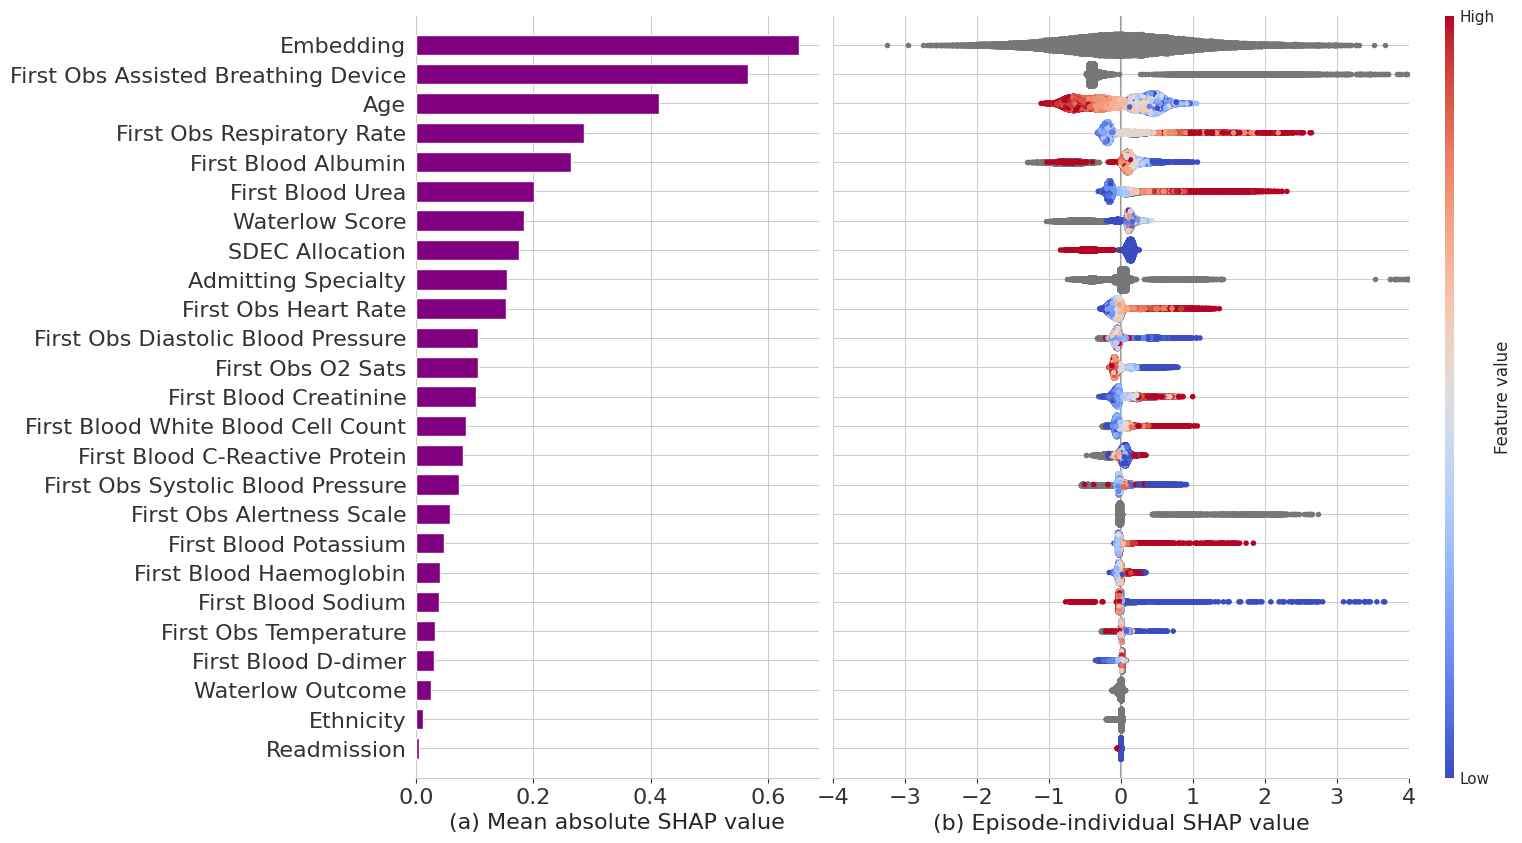

In [155]:
from transformer_experiment.utils.embeddings import plot_shap_features_joint

pretty_print_columns = SalfordPrettyPrint | dict(EMBEDDING="Embedding")
lgbm_explanations.feature_names = [pretty_print_columns[_] for _ in lgbm_explanations.feature_names]
plot_shap_features_joint(lgbm_explanations, 
        max_display=25,
        figsize=(16, 9),
        wspace=-0.2,
        bar_aspect=0.05,
        topadjust=0.925)